## Convolution AutoEncoder

References:

* https://gist.github.com/tomokishii/7ddde510edb1c4273438ba0663b26fc6
* https://github.com/pkmital/tensorflow_tutorials
* https://github.com/chiphuyen/tf-stanford-tutorials

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Convolution 2-D Layer
class Convolution2D(object):
    '''
      constructor's args:
          input     : input image (2D matrix)
          input_siz ; input image size
          in_ch     : number of incoming image channel
          out_ch    : number of outgoing image channel
          patch_siz : filter(patch) size
          weights   : (if input) (weights, bias)
    '''
    def __init__(self, input, input_siz, in_ch, out_ch, patch_siz, activation='relu'):
        self.input = input      
        self.rows = input_siz[0]
        self.cols = input_siz[1]
        self.in_ch = in_ch
        self.activation = activation
        
        wshape = [patch_siz[0], patch_siz[1], in_ch, out_ch]
        
        w_cv = tf.Variable(tf.truncated_normal(wshape, stddev=0.1), 
                            trainable=True)
        b_cv = tf.Variable(tf.constant(0.1, shape=[out_ch]), 
                            trainable=True)
        
        self.w = w_cv
        self.b = b_cv
        self.params = [self.w, self.b]
        
    def output(self):
        shape4D = [-1, self.rows, self.cols, self.in_ch]
        
        x_image = tf.reshape(self.input, shape4D)  # reshape to 4D tensor
        linout = tf.nn.conv2d(x_image, self.w, 
                  strides=[1, 1, 1, 1], padding='SAME') + self.b
        if self.activation == 'relu':
            self.output = tf.nn.relu(linout)
        elif self.activation == 'sigmoid':
            self.output = tf.sigmoid(linout)
        else:
            self.output = linout
        
        return self.output

# Max Pooling Layer   
class MaxPooling2D(object):
    '''
      constructor's args:
          input  : input image (2D matrix)
          ksize  : pooling patch size
    '''
    def __init__(self, input, ksize=None):
        self.input = input
        if ksize == None:
            ksize = [1, 2, 2, 1]
            self.ksize = ksize
    
    def output(self):
        self.output = tf.nn.max_pool(self.input, ksize=self.ksize,
                    strides=[1, 2, 2, 1], padding='SAME')
  
        return self.output

# Full-connected Layer   
class FullConnected(object):
    def __init__(self, input, n_in, n_out):
        self.input = input
    
        w_h = tf.Variable(tf.truncated_normal([n_in,n_out],
                          mean=0.0, stddev=0.05), trainable=True)
        b_h = tf.Variable(tf.zeros([n_out]), trainable=True)
     
        self.w = w_h
        self.b = b_h
        self.params = [self.w, self.b]
    
    def output(self):
        linarg = tf.matmul(self.input, self.w) + self.b
        self.output = tf.nn.relu(linarg)
        
        return self.output

# Read-out Layer
class ReadOutLayer(object):
    def __init__(self, input, n_in, n_out):
        self.input = input
        
        w_o = tf.Variable(tf.random_normal([n_in,n_out],
                        mean=0.0, stddev=0.05), trainable=True)
        b_o = tf.Variable(tf.zeros([n_out]), trainable=True)
       
        self.w = w_o
        self.b = b_o
        self.params = [self.w, self.b]
    
    def output(self):
        linarg = tf.matmul(self.input, self.w) + self.b
        self.output = tf.nn.softmax(linarg)  

        return self.output
#


In [4]:
# Up-sampling 2-D Layer (deconvolutoinal Layer)
class Conv2Dtranspose(object):
    '''
      constructor's args:
          input      : input image (2D matrix)
          output_siz : output image size
          in_ch      : number of incoming image channel
          out_ch     : number of outgoing image channel
          patch_siz  : filter(patch) size
    '''
    def __init__(self, input, output_siz, in_ch, out_ch, patch_siz, activation='relu'):
        self.input = input      
        self.rows = output_siz[0]
        self.cols = output_siz[1]
        self.out_ch = out_ch
        self.activation = activation
        
        wshape = [patch_siz[0], patch_siz[1], out_ch, in_ch]    # note the arguments order
        
        w_cvt = tf.Variable(tf.truncated_normal(wshape, stddev=0.1), 
                            trainable=True)
        b_cvt = tf.Variable(tf.constant(0.1, shape=[out_ch]), 
                            trainable=True)
        self.batsiz = tf.shape(input)[0]
        self.w = w_cvt
        self.b = b_cvt
        self.params = [self.w, self.b]
        
    def output(self):
        shape4D = [self.batsiz, self.rows, self.cols, self.out_ch]      
        linout = tf.nn.conv2d_transpose(self.input, self.w, output_shape=shape4D,
                            strides=[1, 2, 2, 1], padding='SAME') + self.b
        if self.activation == 'relu':
            self.output = tf.nn.relu(linout)
        elif self.activation == 'sigmoid':
            self.output = tf.sigmoid(linout)
        else:
            self.output = linout
        
        return self.output

# Create the model
def model(X, w_e, b_e, w_d, b_d):
    encoded = tf.sigmoid(tf.matmul(X, w_e) + b_e)
    decoded = tf.sigmoid(tf.matmul(encoded, w_d) + b_d)
    
    return encoded, decoded

def mk_nn_model(x, y_):
    # Encoding phase
    x_image = tf.reshape(x, [-1, 28, 28, 1])    
    conv1 = Convolution2D(x_image, (28, 28), 1, 16, 
                          (3, 3), activation='relu')
    conv1_out = conv1.output()
    
    pool1 = MaxPooling2D(conv1_out)
    pool1_out = pool1.output()
    
    conv2 = Convolution2D(pool1_out, (14, 14), 16, 8, 
                          (3, 3), activation='relu')
    conv2_out = conv2.output()
    
    pool2 = MaxPooling2D(conv2_out)
    pool2_out = pool2.output()

    conv3 = Convolution2D(pool2_out, (7, 7), 8, 8, (3, 3), activation='relu')
    conv3_out = conv3.output()

    pool3 = MaxPooling2D(conv3_out)
    pool3_out = pool3.output()
    # at this point the representation is (8, 4, 4) i.e. 128-dimensional
    # Decoding phase
    conv_t1 = Conv2Dtranspose(pool3_out, (7, 7), 8, 8,
                         (3, 3), activation='relu')
    conv_t1_out = conv_t1.output()

    conv_t2 = Conv2Dtranspose(conv_t1_out, (14, 14), 8, 8,
                         (3, 3), activation='relu')
    conv_t2_out = conv_t2.output()

    conv_t3 = Conv2Dtranspose(conv_t2_out, (28, 28), 8, 16, 
                         (3, 3), activation='relu')
    conv_t3_out = conv_t3.output()

    conv_last = Convolution2D(conv_t3_out, (28, 28), 16, 1, (3, 3),
                         activation='sigmoid')
    decoded = conv_last.output()

    decoded = tf.reshape(decoded, [-1, 784])
    cross_entropy = -1. *x *tf.log(decoded) - (1. - x) *tf.log(1. - decoded)
    loss = tf.reduce_mean(cross_entropy)
       
    return loss, decoded  
    

Training...
  step, loss =      0:  0.624
  step, loss =   1000:  0.194
  step, loss =   2000:  0.149
  step, loss =   3000:  0.130
  step, loss =   4000:  0.120
  step, loss =   5000:  0.118
  step, loss =   6000:  0.121
  step, loss =   7000:  0.111
  step, loss =   8000:  0.110
  step, loss =   9000:  0.116
  step, loss =  10000:  0.119
loss (test) =  0.113268


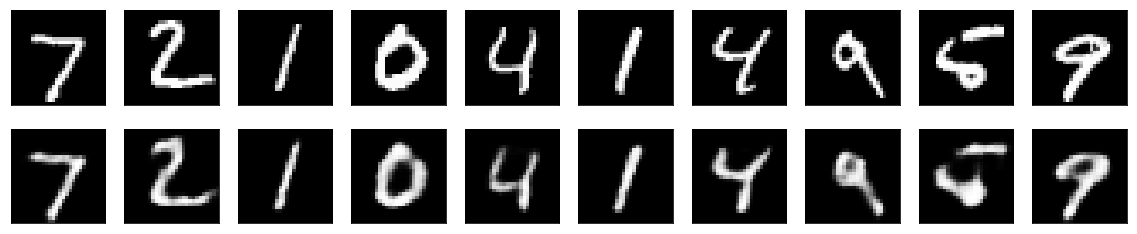

In [6]:
# Variables
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10]) 

loss, decoded = mk_nn_model(x, y_)
train_step = tf.train.AdagradOptimizer(0.1).minimize(loss)

init = tf.global_variables_initializer()
# Train
with tf.Session() as sess:
    sess.run(init)
    print('Training...')
    for i in range(10001):
        batch_xs, batch_ys = mnist.train.next_batch(128)
        train_step.run({x: batch_xs, y_: batch_ys})
        if i % 1000 == 0:
            train_loss= loss.eval({x: batch_xs, y_: batch_ys})
            print('  step, loss = %6d: %6.3f' % (i, train_loss))

    # generate decoded image with test data
    test_fd = {x: mnist.test.images, y_: mnist.test.labels}
    decoded_imgs = decoded.eval(test_fd)
    print('loss (test) = ', loss.eval(test_fd))

x_test = mnist.test.images
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
#plt.savefig('mnist_ae2.png')